# 概要

概要：

・データ：MNISTデータ

・暗黙的拡散モデルの実装

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import itertools
from tqdm.auto import tqdm

# データの準備

In [3]:
import os

os.getcwd()

'/home/hashikami/anaconda3/envs/Diff/content/notebooks'

In [4]:
image_size = 28
channels = 1
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(), # ピクセルの値を[0, 1]範囲に正規化
])

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=False,
    transform=transform
)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size, # ミニバッチのサイズ
    shuffle=True,
    num_workers=2 #データロード時に使用するスレッド数
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2462648.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156051.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1388434.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7159161.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



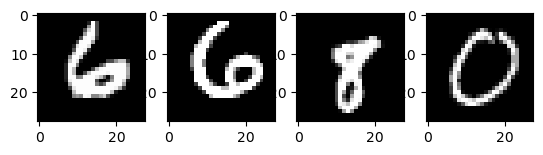

In [5]:
dataiter = iter(trainloader) # イテラブルへ
images, labels = next(dataiter) # 次のイタレーション

fig, axes = plt.subplots(1, 4)
for i in range(4):
  ax = axes[i]
  img = images[i].numpy().squeeze()
  ax.imshow(img, cmap='gray')

plt.show()

# 拡散モデルの実装

## ハイパラ

In [6]:
timesteps = 500

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
  return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(timesteps)
betas = betas.to(device)
alphas_cumprod = torch.cumprod(1. - betas, axis=0)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)

## 拡散過程

In [7]:
def extract(a, t, x_shape: torch.Size):
  """各サンプルのステップtに対応するインデックスの要素を抽出する
    Args:
        a ( T, ): alphasやbetas
        t ( b, ): バッチ内各サンプルのタイムステップt
        x_shape: 画像サイズ
    Returns:
        out ( b, 1, 1, 1 ): xとの計算に使うためxに次元数を合わせて返す
    """
  batch_size = t.shape[0]
  out = a.gather(-1, t.to(a.device))
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def q_sample(x_start, t, noise):
  """Reparameterizationを用いて，実画像x_0からノイズ画像x_tをサンプリングする（拡散過程）
    Args:
        x_start ( b, c, h, w ): 実画像x_0
        t ( b, ): バッチ内各サンプルのタイムステップt
        noise ( b, c, h, w ): 標準ガウス分布からのノイズ (epsilon)
    Returns:
        x_noisy: ( b, c, h, w ): ノイズ画像x_t
  """
  alphas_cumprod_t = extract(alphas_cumprod, t, x_start.shape)

  return torch.sqrt(alphas_cumprod_t) * x_start + torch.sqrt(1 - alphas_cumprod_t) * noise

In [8]:
def p_losses(denoise_model, x_start, t, noise=None):
  """
    Args:
        denoise_model ( nn.Module ): U-Net
        x_start ( b, c, h, w ): 実画像x_0
        t ( b, ): バッチ内各サンプルのタイムステップt
  """
  if noise is None:
    noise = torch.randn_like(x_start)

  x_noisy = q_sample(x_start, t, noise)
  predicted_noise = denoise_model(x_noisy, t)
  loss = F.mse_loss(noise, predicted_noise)

  return loss

## 逆拡散過程

posterior_variance:$q(x_{t-1}|x_t, x_0)$の分散パラメータ$\tilde{\beta}_t=\frac{1 - \alpha_{t-1}}{1 - \alpha_t}\beta_t$

逆拡散過程

$x_{t-1} = \frac{1}{\sqrt{1 - \beta_t}}\left(x_t - \frac{\beta_t}{\sqrt{1 - \alpha_t}}\epsilon_{\theta}(x_t,t)\right) + \sigma_t z$

In [9]:
# DDPM用

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

@torch.no_grad()
def p_sample(denoise_model, x, t_index):
  """1ステップ逆過程を進む
    Args:
        model ( nn.Module ): U-Net
        x ( b, c, h, w ): ノイズ画像x_t
        t_index ( int ): サンプリングループにおける現在のタイムステップt（サンプル共通）
    Returns:
        x ( b, c, h, w ): ノイズ画像x_{t-1} or 実画像x_0
  """
  t = torch.full((x.shape[0],), t_index, device=x.device, dtype=torch.long) # t_index値が(b,)の形で並ぶ
  betas_t = extract(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(torch.sqrt(1.0 - alphas_cumprod), t, x.shape)
  coef_t = extract(torch.sqrt(1.0 / (1. - betas)), t, x.shape)
  model_mean = coef_t * (x - betas_t * denoise_model(x, t) / sqrt_one_minus_alphas_cumprod_t)
  if t_index == 0:
    return model_mean
  else:
    posterior_variance_t = extract(posterior_variance, t, x.shape)
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(denoise_model, image_size, batch_size=16, channels=1):
  """逆過程のステップを繰り返し，画像を生成する
    Args:
        model ( nn.Module ): U-Net
        image_size ( int ): 画像サイズ
    Returns:
        imgs ( b, c, h, w ): 生成画像
  """

  # 純粋なノイズから逆過程を始める
  shape = (batch_size, channels, image_size, image_size)
  img = torch.randn(shape, device=device)

  # ループ
  imgs = []
  for t in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample(denoise_model, img, t)
    imgs.append(img.cpu().numpy())

  return imgs

In [23]:
# DDIM用

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# one step sample 1
@torch.no_grad()
def ddim_p_sample(denoise_model, x, t_index, eta):
  """1ステップ逆過程を進む
    Args:
        model ( nn.Module ): U-Net
        x ( b, c, h, w ): ノイズ画像x_t
        t_index ( int ): サンプリングループにおける現在のタイムステップt（サンプル共通）
        prev_t_index ( int ): サンプリングループにおける前のステップ
        eta ( float ): DDIMのノイズに関するハイパーパラメータ
    Returns:
        x ( b, c, h, w ): ノイズ画像x_{t-1} or 実画像x_0
  """
  t = torch.full((x.shape[0],), t_index, device=x.device, dtype=torch.long)
  
  alphas_t = extract(alphas_cumprod, t, x.shape)
  alphas_prev_t = extract(alphas_cumprod_prev, t, x.shape)

  # predict noise using model
  epsilon_theta_t = denoise_model(x, t)

  # calculate x_{t-1}
  sigma_t = eta * torch.sqrt((1 - alphas_prev_t) / (1 - alphas_t) * (1 - alphas_t / alphas_prev_t))
  epsilon_t = torch.randn_like(x)
  x_t_minus_one = (
          torch.sqrt(alphas_prev_t / alphas_t) * x +
          (torch.sqrt(1 - alphas_prev_t - sigma_t ** 2) - torch.sqrt(
              (alphas_prev_t * (1 - alphas_t)) / alphas_t)) * epsilon_theta_t +
          sigma_t * epsilon_t
  )
  return x_t_minus_one
    


@torch.no_grad()
def ddim_p_sample_loop(denoise_model, image_size, batch_size=16, channels=1, eta=0.0):
  """逆過程のステップを繰り返し，画像を生成する
    Args:
        model ( nn.Module ): U-Net
        image_size ( int ): 画像サイズ
    Returns:
        imgs ( b, c, h, w ): 生成画像
  """

  # 純粋なノイズから逆過程を始める
  shape = (batch_size, channels, image_size, image_size)
  img = torch.randn(shape, device=device)

  # ループ
  imgs = []
  for t in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = ddim_p_sample(denoise_model, img, t, eta)
    imgs.append(img.cpu().numpy())

  return imgs

  
  

In [26]:
def plot_samples(denoise_model, batch_size):
    imgs = p_sample_loop(denoise_model, image_size=28, batch_size=batch_size, channels=1)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax = axes[i]
        img = imgs[499][i].squeeze()
        ax.imshow(img, cmap='gray')

    plt.show()

In [27]:
# DDIM用

def ddim_plot_samples(denoise_model, batch_size):
    imgs = ddim_p_sample_loop(denoise_model, image_size=28, batch_size=batch_size, channels=1)
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 3))
    for i in range(batch_size):
        ax = axes[i]
        img = imgs[499][i].squeeze()
        ax.imshow(img, cmap='gray')

    plt.show()


## モデルの実装

### 実装1

概要：

・特徴マップの次元数は28->14->7->3まで落とした

In [7]:
# by chatgpt

class DoubleConv(nn.Module):
  """
  二つの畳み込み層とReLU関数からなるモジュール

  Args:
    in_channels (int): Number of input channels
    out_channels (int): Number of output channels

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channles, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


class Down(nn.Module):
  """
  DoubleConvとMaxPoolingを用いてダウンサンプルするモジュール

  Args:
    in_channels (int): Number of input channels
    out_channles (int): Numer of output channles

  Input:
    x (torch.Tensor): shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): shape (batch_size, out_channels, height // 2, width // 2)
  """
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()

    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    return x


class Up(nn.Module):
  """
  DoubleConvを用いたアップサンプリングを行うモジュール

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x1 (torch.Tensor): アップサンプリングを受けるテンソル (batch_size, in_channels, height, width)
    x2 (torch.Tensor): スキップ接続で受け取るテンソル (batch_size, in_channels // 2, height * 2, width * 2)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height * 2, width * 2)
  """

  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2) # 転置畳み込み 画像サイズが2倍に
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1) # x1のアップサンプル
    diffX = x2.size()[2] - x1.size()[2] # x1とx2の高さの差
    diffY = x2.size()[3] - x1.size()[3] # x1とx2の幅の差
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # スキップ接続 channelの次元で結合
    return self.conv(x)


class OutConv(nn.Module):
  """
  最終的な畳み込み層。最終出力に合うようにchannels数を合わせる

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class TimeEmbedding(nn.Module):
  """
  時間ステップを高次元空間に埋め込むためのモジュール

  Args:
    dim (int): Dimension of the embedding space

  Input:
    t (torch.Tensor): Tensor of shape (batch_size, )

  Output:
    t_emb (torch.Tensor): Tensor of shape(batch_size, dim, 1, 1)
  """

  def __init__(self, dim):
    super(TimeEmbedding, self).__init__()
    self.fc = nn.Linear(1, dim)
    self.conv = nn.Conv2d(dim, 512, kernel_size=1) # 64 => 512(ボトルネック次元)

  def forward(self, t):
    t = t[:, None].float() # (batch_size,) to (batch_size, 1)
    t_emb = self.fc(t).unsqueeze(-1).unsqueeze(-1) # (batch, dim) to (batch, dim, 1, 1)
    t_emb = self.conv(t_emb) # to (b, 512, 1, 1)
    return t_emb

In [8]:
class DenoiseModel(nn.Module):
  """
  時刻情報tを埋め込んだU-Netの実装

  Args:
    n_channels (int): Number of input channels
    n_classes (int): Number of output channels
    time_dim (int): Dimension of the time embedding space.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, n_channels, height, width)
    t (torch.Tensor): Tensor of shape (batch_size,)

  Output:
    logits (torch.Tensor): Tensor of shape (batch_size, n_classes, height, width)
  """

  def __init__(self, n_channels=1, n_classes=1, time_dim=64):
    super(DenoiseModel, self).__init__()
    self.time_dim = time_dim

    self.inc = DoubleConv(n_channels, 64) # (batch_size, n_channels, height, width) to (batch_size, 64, height, width)
    self.down1 = Down(64, 128) # to (b, 128, h/2, w/2)
    self.down2 = Down(128, 256) # to (b, 256, h/4, w/4)
    self.down3 = Down(256, 512) # to (b, 512, h/8, w/8)
    self.up1 = Up(512, 256) # (b, 512 + 512, h/8, w/8) to (b, 256, h/4, w/4) スキップ接続
    self.up2 = Up(256, 128) # (b, 256 + 256, h/4, w/4) to (b, 128, h/2, h/2)
    self.up3 = Up(128, 64) # (b, 128 + 128, h/2, w/2) to (b, 64, h, w)
    self.outc = OutConv(64, n_classes) # to (b, n_classes, h, w)

    self.time_embed = TimeEmbedding(time_dim)


  def forward(self, x, t):
    t_embed = self.time_embed(t)
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    x4 = x4 + t_embed

    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    logits = self.outc(x)
    return logits

### 実装2

概要：

・特徴マップは28->14->7で止める

・

In [10]:
# by chatgpt

class DoubleConv(nn.Module):
  """
  二つの畳み込み層とReLU関数からなるモジュール

  Args:
    in_channels (int): Number of input channels
    out_channels (int): Number of output channels

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channles, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


class Down(nn.Module):
  """
  DoubleConvとMaxPoolingを用いてダウンサンプルするモジュール

  Args:
    in_channels (int): Number of input channels
    out_channles (int): Numer of output channles

  Input:
    x (torch.Tensor): shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): shape (batch_size, out_channels, height // 2, width // 2)
  """
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()

    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    return x


class Up(nn.Module):
  """
  DoubleConvを用いたアップサンプリングを行うモジュール

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x1 (torch.Tensor): アップサンプリングを受けるテンソル (batch_size, in_channels, height, width)
    x2 (torch.Tensor): スキップ接続で受け取るテンソル (batch_size, in_channels // 2, height * 2, width * 2)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height * 2, width * 2)
  """

  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2) # 転置畳み込み 画像サイズが2倍に
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1) # x1のアップサンプル
    diffX = x2.size()[2] - x1.size()[2] # x1とx2の高さの差
    diffY = x2.size()[3] - x1.size()[3] # x1とx2の幅の差
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # スキップ接続 channelの次元で結合
    return self.conv(x)


class OutConv(nn.Module):
  """
  最終的な畳み込み層。最終出力に合うようにchannels数を合わせる

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class TimeEmbedding(nn.Module):
  """
  時間ステップを高次元空間に埋め込むためのモジュール

  Args:
    dim (int): Dimension of the embedding space

  Input:
    t (torch.Tensor): Tensor of shape (batch_size, )

  Output:
    t_emb (torch.Tensor): Tensor of shape(batch_size, dim, 1, 1)
  """

  def __init__(self, dim):
    super(TimeEmbedding, self).__init__()
    self.fc = nn.Linear(1, dim)
    #self.conv = nn.Conv2d(dim, 512, kernel_size=1) # 64 => 512(ボトルネック次元
    self.conv = nn.Conv2d(dim, 256, kernel_size=1) # 64 => 256

  def forward(self, t):
    t = t[:, None].float() # (batch_size,) to (batch_size, 1)
    t_emb = self.fc(t).unsqueeze(-1).unsqueeze(-1) # (batch, dim) to (batch, dim, 1, 1)
    t_emb = self.conv(t_emb) # to (b, 512, 1, 1)
    return t_emb

In [13]:
class DenoiseModel(nn.Module):
  """
  時刻情報tを埋め込んだU-Netの実装

  Args:
    n_channels (int): Number of input channels
    n_classes (int): Number of output channels
    time_dim (int): Dimension of the time embedding space.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, n_channels, height, width)
    t (torch.Tensor): Tensor of shape (batch_size,)

  Output:
    logits (torch.Tensor): Tensor of shape (batch_size, n_classes, height, width)
  """

  def __init__(self, n_channels=1, n_classes=1, time_dim=64):
    super(DenoiseModel, self).__init__()
    self.time_dim = time_dim

    self.inc = DoubleConv(n_channels, 64) # (batch_size, n_channels, height, width) to (batch_size, 64, height, width)
    self.down1 = Down(64, 128) # to (b, 128, h/2, w/2)
    self.down2 = Down(128, 256) # to (b, 256, h/4, w/4)
    #self.down3 = Down(256, 512) # to (b, 512, h/8, w/8)
    #self.up1 = Up(512, 256) # (b, 512 + 512, h/8, w/8) to (b, 256, h/4, w/4) スキップ接続
    self.up2 = Up(256, 128) # (b, 256 + 256, h/4, w/4) to (b, 128, h/2, h/2)
    self.up3 = Up(128, 64) # (b, 128 + 128, h/2, w/2) to (b, 64, h, w)
    self.outc = OutConv(64, n_classes) # to (b, n_classes, h, w)

    self.time_embed = TimeEmbedding(time_dim)


  def forward(self, x, t):
    t_embed = self.time_embed(t)
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    #x4 = self.down3(x3)

    #x4 = x4 + t_embed
    x3 = x3 + t_embed

    """
    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    """
    x = self.up2(x3, x2)
    x = self.up3(x, x1)

    logits = self.outc(x)
    return logits

### 実装3

検証

・28->14->7->3とする

・バッチ正規化を多用する

結果

勾配消失問題は以下のようにかなり改善された

![Untitle](./validation/validation3.png)



In [35]:
# by chatgpt

class DoubleConv(nn.Module):
  """
  二つの畳み込み層とReLU関数からなるモジュール

  Args:
    in_channels (int): Number of input channels
    out_channels (int): Number of output channels

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channles, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels), # バッチ正規化を付加
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels), # バッチ正規化を付加
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


class Down(nn.Module):
  """
  DoubleConvとMaxPoolingを用いてダウンサンプルするモジュール

  Args:
    in_channels (int): Number of input channels
    out_channles (int): Numer of output channles

  Input:
    x (torch.Tensor): shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): shape (batch_size, out_channels, height // 2, width // 2)
  """
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()

    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    return x


class Up(nn.Module):
  """
  DoubleConvを用いたアップサンプリングを行うモジュール

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x1 (torch.Tensor): アップサンプリングを受けるテンソル (batch_size, in_channels, height, width)
    x2 (torch.Tensor): スキップ接続で受け取るテンソル (batch_size, in_channels // 2, height * 2, width * 2)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height * 2, width * 2)
  """

  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2) # 転置畳み込み 画像サイズが2倍に
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1) # x1のアップサンプル
    diffX = x2.size()[2] - x1.size()[2] # x1とx2の高さの差
    diffY = x2.size()[3] - x1.size()[3] # x1とx2の幅の差
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # スキップ接続 channelの次元で結合
    return self.conv(x)


class OutConv(nn.Module):
  """
  最終的な畳み込み層。最終出力に合うようにchannels数を合わせる

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class TimeEmbedding(nn.Module):
  """
  時間ステップを高次元空間に埋め込むためのモジュール

  Args:
    dim (int): Dimension of the embedding space

  Input:
    t (torch.Tensor): Tensor of shape (batch_size, )

  Output:
    t_emb (torch.Tensor): Tensor of shape(batch_size, dim, 1, 1)
  """

  def __init__(self, dim):
    super(TimeEmbedding, self).__init__()
    self.fc = nn.Linear(1, dim)
    self.conv = nn.Conv2d(dim, 512, kernel_size=1) # 64 => 512(ボトルネック次元)

  def forward(self, t):
    t = t[:, None].float() # (batch_size,) to (batch_size, 1)
    t_emb = self.fc(t).unsqueeze(-1).unsqueeze(-1) # (batch, dim) to (batch, dim, 1, 1)
    t_emb = self.conv(t_emb) # to (b, 512, 1, 1)
    return t_emb

In [36]:
class DenoiseModel(nn.Module):
  """
  時刻情報tを埋め込んだU-Netの実装

  Args:
    n_channels (int): Number of input channels
    n_classes (int): Number of output channels
    time_dim (int): Dimension of the time embedding space.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, n_channels, height, width)
    t (torch.Tensor): Tensor of shape (batch_size,)

  Output:
    logits (torch.Tensor): Tensor of shape (batch_size, n_classes, height, width)
  """

  def __init__(self, n_channels=1, n_classes=1, time_dim=64):
    super(DenoiseModel, self).__init__()
    self.time_dim = time_dim

    self.inc = DoubleConv(n_channels, 64) # (batch_size, n_channels, height, width) to (batch_size, 64, height, width)
    self.down1 = Down(64, 128) # to (b, 128, h/2, w/2)
    self.down2 = Down(128, 256) # to (b, 256, h/4, w/4)
    self.down3 = Down(256, 512) # to (b, 512, h/8, w/8)
    self.up1 = Up(512, 256) # (b, 512 + 512, h/8, w/8) to (b, 256, h/4, w/4) スキップ接続
    self.up2 = Up(256, 128) # (b, 256 + 256, h/4, w/4) to (b, 128, h/2, h/2)
    self.up3 = Up(128, 64) # (b, 128 + 128, h/2, w/2) to (b, 64, h, w)
    self.outc = OutConv(64, n_classes) # to (b, n_classes, h, w)

    self.time_embed = TimeEmbedding(time_dim)


  def forward(self, x, t):
    t_embed = self.time_embed(t)
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    x4 = x4 + t_embed

    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    logits = self.outc(x)
    return logits

### 実装4

検証

・28->14->7->3とする

・グループ正規化を多用する

結果



In [12]:
# by chatgpt

class DoubleConv(nn.Module):
  """
  二つの畳み込み層とReLU関数からなるモジュール

  Args:
    in_channels (int): Number of input channels
    out_channels (int): Number of output channels

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channles, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels, num_groups=1):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups, out_channels), # グループ正規化
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups, out_channels), # グループ正規化
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


class Down(nn.Module):
  """
  DoubleConvとMaxPoolingを用いてダウンサンプルするモジュール

  Args:
    in_channels (int): Number of input channels
    out_channles (int): Numer of output channles

  Input:
    x (torch.Tensor): shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): shape (batch_size, out_channels, height // 2, width // 2)
  """
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()

    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    return x


class Up(nn.Module):
  """
  DoubleConvを用いたアップサンプリングを行うモジュール

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x1 (torch.Tensor): アップサンプリングを受けるテンソル (batch_size, in_channels, height, width)
    x2 (torch.Tensor): スキップ接続で受け取るテンソル (batch_size, in_channels // 2, height * 2, width * 2)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height * 2, width * 2)
  """

  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2) # 転置畳み込み 画像サイズが2倍に
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1) # x1のアップサンプル
    diffX = x2.size()[2] - x1.size()[2] # x1とx2の高さの差
    diffY = x2.size()[3] - x1.size()[3] # x1とx2の幅の差
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1) # スキップ接続 channelの次元で結合
    return self.conv(x)


class OutConv(nn.Module):
  """
  最終的な畳み込み層。最終出力に合うようにchannels数を合わせる

  Args:
    in_channels (int): Number of input channels.
    out_channels (int): Number of output channels.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, in_channels, height, width)

  Output:
    x (torch.Tensor): Tensor of shape (batch_size, out_channels, height, width)
  """

  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class TimeEmbedding(nn.Module):
  """
  時間ステップを高次元空間に埋め込むためのモジュール

  Args:
    dim (int): Dimension of the embedding space

  Input:
    t (torch.Tensor): Tensor of shape (batch_size, )

  Output:
    t_emb (torch.Tensor): Tensor of shape(batch_size, dim, 1, 1)
  """

  def __init__(self, dim):
    super(TimeEmbedding, self).__init__()
    self.fc = nn.Linear(1, dim)
    self.conv = nn.Conv2d(dim, 512, kernel_size=1) # 64 => 512(ボトルネック次元)

  def forward(self, t):
    t = t[:, None].float() # (batch_size,) to (batch_size, 1)
    t_emb = self.fc(t).unsqueeze(-1).unsqueeze(-1) # (batch, dim) to (batch, dim, 1, 1)
    t_emb = self.conv(t_emb) # to (b, 512, 1, 1)
    return t_emb

In [13]:
class DenoiseModel(nn.Module):
  """
  時刻情報tを埋め込んだU-Netの実装

  Args:
    n_channels (int): Number of input channels
    n_classes (int): Number of output channels
    time_dim (int): Dimension of the time embedding space.

  Input:
    x (torch.Tensor): Tensor of shape (batch_size, n_channels, height, width)
    t (torch.Tensor): Tensor of shape (batch_size,)

  Output:
    logits (torch.Tensor): Tensor of shape (batch_size, n_classes, height, width)
  """

  def __init__(self, n_channels=1, n_classes=1, time_dim=64):
    super(DenoiseModel, self).__init__()
    self.time_dim = time_dim

    self.inc = DoubleConv(n_channels, 64) # (batch_size, n_channels, height, width) to (batch_size, 64, height, width)
    self.down1 = Down(64, 128) # to (b, 128, h/2, w/2)
    self.down2 = Down(128, 256) # to (b, 256, h/4, w/4)
    self.down3 = Down(256, 512) # to (b, 512, h/8, w/8)
    self.up1 = Up(512, 256) # (b, 512 + 512, h/8, w/8) to (b, 256, h/4, w/4) スキップ接続
    self.up2 = Up(256, 128) # (b, 256 + 256, h/4, w/4) to (b, 128, h/2, h/2)
    self.up3 = Up(128, 64) # (b, 128 + 128, h/2, w/2) to (b, 64, h, w)
    self.outc = OutConv(64, n_classes) # to (b, n_classes, h, w)

    self.time_embed = TimeEmbedding(time_dim)


  def forward(self, x, t):
    t_embed = self.time_embed(t)
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    x4 = x4 + t_embed

    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    logits = self.outc(x)
    return logits

## 学習の実行

In [15]:
def save_checkpoint(denoise_model, optimizer, scheduler, epoch, loss, filename='checkpoint.pth'):
  checkpoint = {
      'denoise_model_state_dict': denoise_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'epoch': epoch,
      'loss': loss
  }
  torch.save(checkpoint, filename)

def load_checkpoint(denoise_model, optimizer, scheduler, filename='checkpoint.pth'):
  checkpoint = torch.load(filename)
  denoise_model.load_state_dict(checkpoint['denoise_model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return denoise_model, optimizer, scheduler, epoch, loss

In [17]:
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

denoise_model = DenoiseModel().to(device)
optimizer = optim.Adam(denoise_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[int(epochs * ratio) for ratio in [0.5, 0.8]],
    gamma=0.2
)

In [ ]:
start_epoch = 0

In [19]:
# checkpointからスタート
denoise_model, optimizer, scheduler, start_epoch, loss = load_checkpoint(denoise_model, optimizer, scheduler, filename='../checkpoint/checkpoint7.pth')

In [20]:
bar = tqdm(range(start_epoch, epochs))
save_interval = 10
plot_interval = 50

losses = []

for e in bar:
  for step, (images, _) in enumerate(trainloader):
    optimizer.zero_grad()

    b = images.shape[0]
    images = images.to(device)
    t = torch.randint(0, timesteps, (b, ), device=device).long()
    loss = p_losses(denoise_model, images , t)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  scheduler.step()

  bar.set_description(f'Loss: {loss.item():4f}')

  if (e + 1) % save_interval == 0:
    save_checkpoint(denoise_model, optimizer, scheduler, e + 1, loss.item(), filename='./checkpoint/checkpoint7.pth')
    
  if (e + 1) % plot_interval == 0:
    plot_samples(denoise_model, 5)

  0%|          | 0/350 [00:00<?, ?it/s]

## 生成

In [16]:
denoise_model, optimizer, scheduler, start_epoch, loss = load_checkpoint(denoise_model, optimizer, scheduler, filename='./checkpoint/checkpoint7.pth')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

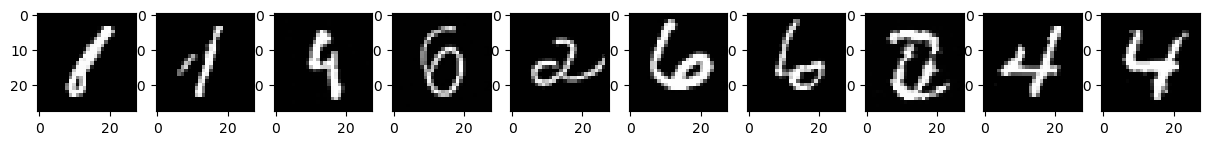

In [28]:
ddim_plot_samples(denoise_model, 10)

# 勾配消失問題の確認

In [47]:
import matplotlib.pyplot as plt

def plot_gradients(model):
    gradients = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    plt.plot(gradients)
    plt.xlabel("Layer")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norms by Layer")
    plt.show()

In [48]:
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

denoise_model = DenoiseModel().to(device)
optimizer = optim.Adam(denoise_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[int(epochs * ratio) for ratio in [0.5, 0.8]],
    gamma=0.2
)

  0%|          | 0/10 [00:00<?, ?it/s]

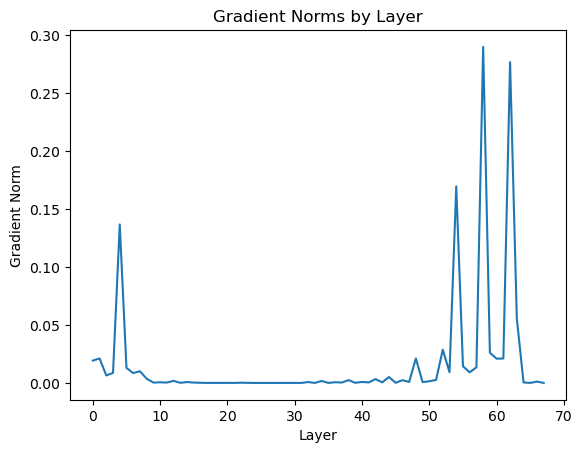

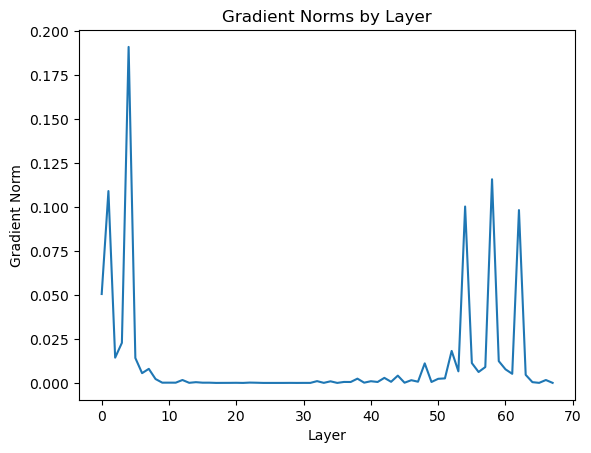

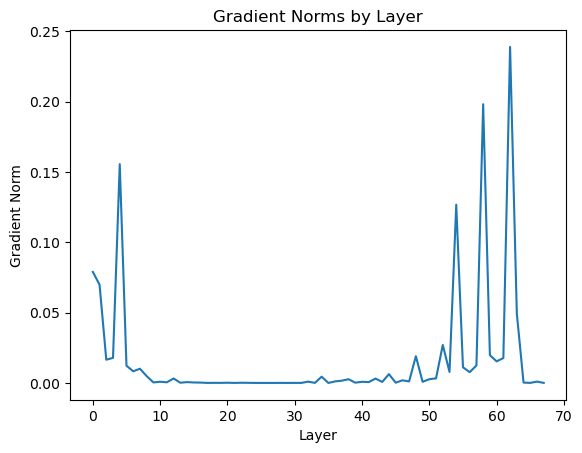

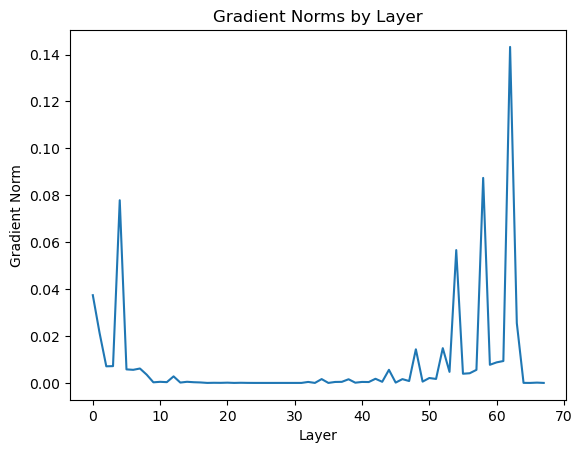

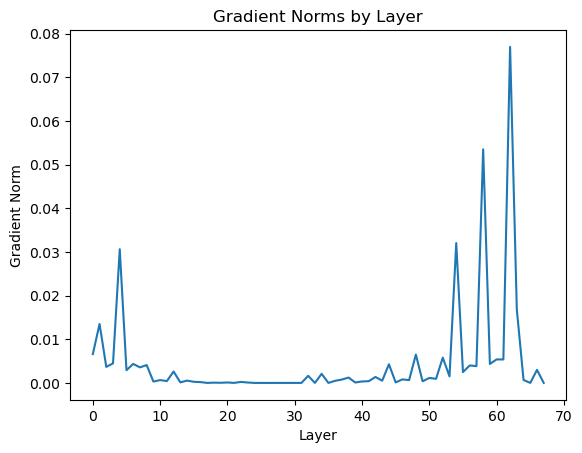

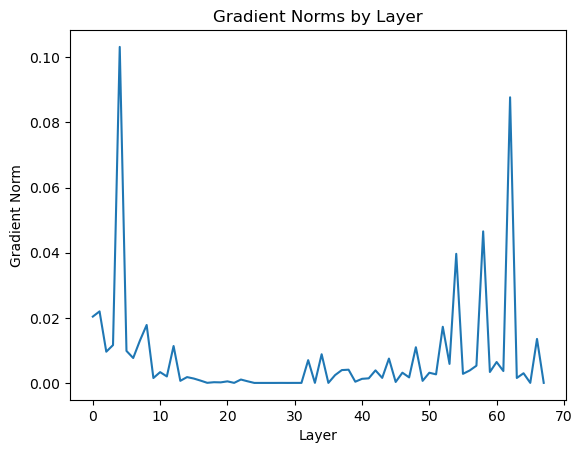

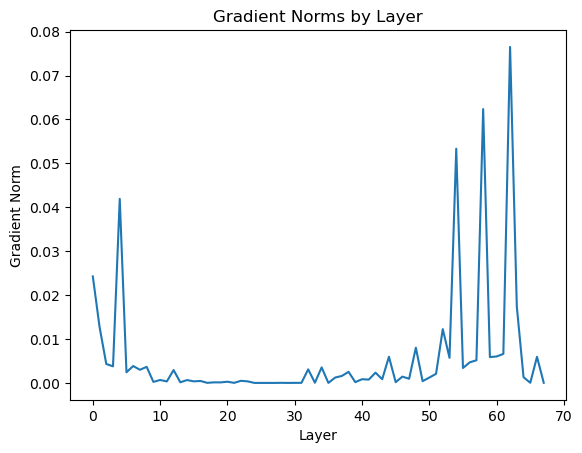

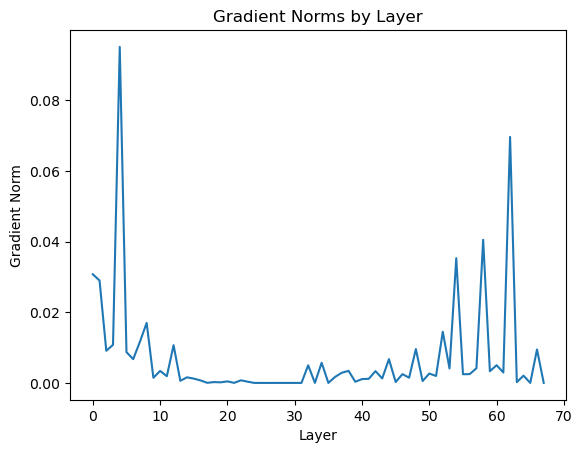

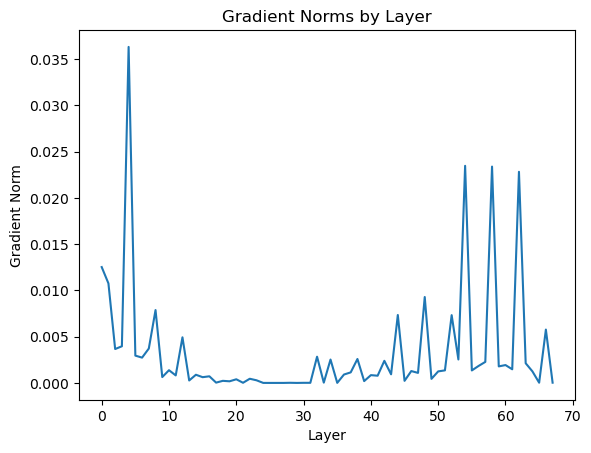

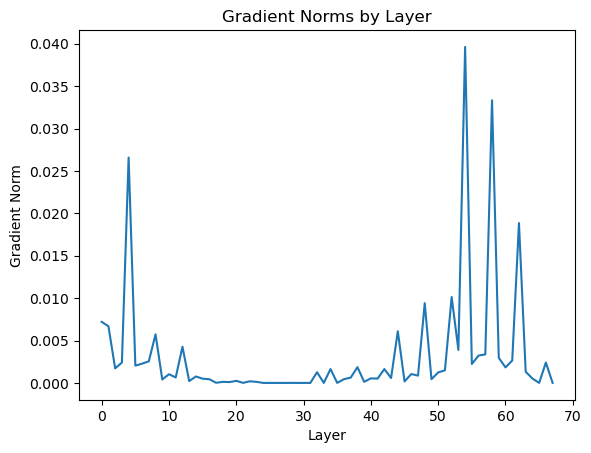

In [49]:
start_epoch = 0

bar = tqdm(range(start_epoch, epochs))

losses = []

for e in bar:
  for step, (images, _) in enumerate(trainloader):
    optimizer.zero_grad()

    b = images.shape[0]
    images = images.to(device)
    t = torch.randint(0, timesteps, (b, ), device=device).long()
    loss = p_losses(denoise_model, images , t)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  scheduler.step()
  plot_gradients(denoise_model)

  bar.set_description(f'Loss: {loss.item():4f}')

  